In [ ]:
from google.colab import drive
import sys



drive.mount('/content/drive')

!pip install opencv-python-headless==4.5.4.60
!pip install fiftyone
#!pip install torch torchvision


sys.path.append('/content/drive/MyDrive/Thesis/SSD')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.coco as fouc
from fiftyone.utils.eval.coco import COCODetectionResults
import torch
import torchvision
import os
import csv
import numpy as np
from PIL import Image
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from src.model import Textboxes, ResNet
from src.dataset import CustomDataset, collate_fn
from torch.utils.data import DataLoader
from src.transform import SSDTransformer
from src.utils import generate_dboxes, Encoder
from plot import read_results, plot_pr_curves
from eval_protocols.icdar import ICDAR_results
from eval_protocols.deteval import DetEval_results
import json
import shutil
import glob
import zipfile

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##Datasets

###Validation dataset

In [ ]:
val_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path="/content/drive/MyDrive/Thesis/new_custom_val_v2",
    labels_path="/content/drive/MyDrive/Thesis/annotations/new_custom_val_v2_big.json",
    include_id=True
)

classes = val_dataset.default_classes
val_dataset.persistent = True
val_samples = [(sample.filepath, sample.coco_id) for sample in val_dataset.iter_samples()]

 100% |███████████████| 3863/3863 [1.7m elapsed, 0s remaining, 29.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [1.7m elapsed, 0s remaining, 29.0 samples/s]      


In [ ]:
import zipfile

root = "/content/drive/MyDrive/Thesis/SSD/eval_protocols"

input_json = "/content/drive/MyDrive/Thesis/annotations/new_custom_val_v2_big.json"
with open(input_json) as json_file:
    coco = json.load(json_file)
    image_ids = set()
    data = coco['annotations']

    # Create the directory 'gt' if it doesn't exist
    if not os.path.exists(os.path.join(root, 'gt')):
        os.makedirs(os.path.join(root, 'gt'))

    # Step 1: Iterate through the array
    for entry in data:
        image_id = entry['image_id']
        bbox = entry['bbox']
        filename = os.path.join(root, f"gt/gt_img_{image_id}.txt")
        with open(filename, 'a') as f: # Open the file in append mode
            f.write(f"{bbox[0]},{bbox[1]},{bbox[0]+bbox[2]},{bbox[1]+bbox[3]},Text\n")

KeyboardInterrupt: ignored

### Visualization dataset

In [ ]:
vis_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path="/content/drive/MyDrive/Thesis/visu",
    labels_path="/content/drive/MyDrive/Thesis/annotations/visu.json",
    include_id=True
)

classes = vis_dataset.default_classes
vis_dataset.persistent = True
vis_samples = [(sample.filepath, sample.coco_id) for sample in vis_dataset.iter_samples()]

 100% |███████████████████| 52/52 [70.0ms elapsed, 0s remaining, 742.8 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 52/52 [70.0ms elapsed, 0s remaining, 742.8 samples/s]  


## Utils




In [ ]:


def save_predictions(predictions, model_name, dataset_name):
  output_dir = "/content/drive/MyDrive/Thesis/SSD/predictions"

  # Define the name of the CSV file you want to create
  filename = os.path.join(output_dir,dataset_name + "_" + model_name + ".csv")

  # Define the fieldnames for the first row of the CSV file
  fieldnames = ["image_id", "category_id", "bbox", "score"]

  # Open the CSV file in "write" mode
  with open(filename, mode="w", newline="") as csv_file:

      # Create a writer object using the csv library
      writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

      # Write the first row (i.e., the fieldnames)
      writer.writeheader()
      for prediction in predictions:
        int_bbox = []
        for val in prediction["bbox"]:
          int_bbox.append(int(val))
        prediction["bbox"] = int_bbox #reduce memory
        # Write the content of your dictionary to the CSV file
        writer.writerow(prediction)

def read_predictions(model_names, dataset="new_custom_val_v2"):
  input_dir = os.path.join("/content/drive/MyDrive/Thesis/SSD/predictions",dataset)
  predictions_models = [[] for _ in model_names]
  for i, name in enumerate(model_names):
    # Define the name of the CSV file you want to read
    if dataset == "new_custom_val_v2":
      filename = "val_v2_big_" + name + ".csv"
    else:
      filename = name + ".csv"
    filename = os.path.join(input_dir, filename)
    # Open the CSV file in "read" mode
    with open(filename, mode="r", newline="") as csv_file:
        # Create a reader object using the csv library
        reader = csv.DictReader(csv_file)

        # Define an empty list to store the contents of the CSV file
        contents = []

        # Loop through each row in the CSV file
        for row in reader:
            row["image_id"] = int(row["image_id"])
            row["category_id"] = int(row["category_id"])
            row["bbox"] = eval(row["bbox"])
            row["score"] = float(row["score"])

            # Add the row to the contents list
            if len(row["bbox"]) == 4:
              contents.append(row)
        predictions_models[i] = contents
  return predictions_models

def pred_to_zip(predictions_models, model_names):
  root = "/content/drive/MyDrive/Thesis/SSD/eval_protocols"
  for i, model_name in enumerate(model_names):

    if os.path.exists(os.path.join(root,model_name + ".zip")):
      continue
    
    skip_step = False
    if not os.path.exists(os.path.join(root,model_name)):
      os.makedirs(os.path.join(root, model_name))
    else:
      skip_step = True

    if not skip_step:
      for entry in predictions_models[i]:
        image_id = entry['image_id']
        bbox = entry['bbox']
        filename = os.path.join(root, f"{model_name}/res_img_{image_id}.txt")
        with open(filename, 'a') as f: # Open the file in append mode
            f.write(f"{bbox[0]},{bbox[1]},{bbox[0]+bbox[2]},{bbox[1]+bbox[3]}\n")

    zipf = zipfile.ZipFile(os.path.join(root, f'{model_name}.zip'), 'w', zipfile.ZIP_DEFLATED)
    zipdir(os.path.join(root, model_name), zipf)
    zipf.close()
    shutil.rmtree(os.path.join(root, model_name))

def predict_samples(vis_samples, model, model_name, transformer):
  encoder = Encoder(dboxes)
  category_ids = test_loader[0].dataset.coco.getCatIds()

  nms_threshold = 0.5
  predictions = []
  for filepath, img_id in vis_samples:
    img = Image.open(filepath).convert("RGB")
    width, height = img.size
    if "split" in model_name:
        quarter_width = width // 2
        quarter_height = height // 2

        # Split the image into four quarters
        top_left = img.crop((0, 0, quarter_width, quarter_height))
        top_right = img.crop((quarter_width, 0, width, quarter_height))
        bottom_left = img.crop((0, quarter_height, quarter_width, height))
        bottom_right = img.crop((quarter_width, quarter_height, width, height))

        quarters = [top_left, top_right, bottom_left, bottom_right]
        
        for q, quarter in enumerate(quarters):
          quarter, _, _, _ = transformer(quarter, None, torch.zeros(1,4), torch.zeros(1))
          if torch.cuda.is_available():
              quarter = quarter.cuda()
          with torch.no_grad():
              # Get predictions
              ploc, plabel = model(quarter.unsqueeze(0))
              ploc, plabel = ploc.float(), plabel.float()
              
              result = encoder.decode_batch(ploc, plabel,nms_threshold , 200)[0]
              
              loc, label, prob = [r.cpu().numpy() for r in result]

              for loc_, label_, prob_ in zip(loc, label, prob):
                  xmin,ymin, w, h = loc_[0]/2,loc_[1]/2,(loc_[2] - loc_[0])/2,(loc_[3] - loc_[1])/2
                  if q == 1 or q ==3:
                      xmin += 0.5
                  if q == 2 or q ==3:
                      ymin += 0.5
                  xmin, w = xmin*width, w*width
                  ymin, h = ymin*height, h*height

                  pred = {"image_id": img_id, "category_id": category_ids[label_ - 1], "bbox": [xmin, ymin, w, h], "score": prob_}
                  predictions.append(pred)
    else: 
          img, _, _, _ = transformer(img, None, torch.zeros(1,4), torch.zeros(1))
          if torch.cuda.is_available():
              img = img.cuda()
          with torch.no_grad():
              # Get predictions
              ploc, plabel = model(img.unsqueeze(0))
              ploc, plabel = ploc.float(), plabel.float()

              result = encoder.decode_batch(ploc, plabel,nms_threshold , 200)[0]

              loc, label, prob = [r.cpu().numpy() for r in result]

              for loc_, label_, prob_ in zip(loc, label, prob):
                  xmin,ymin, w, h = loc_[0] * width, loc_[1] * height, (loc_[2] - loc_[0]) * width, (loc_[3] - loc_[1]) * height
                  pred = {"image_id": img_id, "category_id": category_ids[label_ - 1], "bbox": [xmin, ymin, w, h], "score": prob_}
                  predictions.append(pred)

  return predictions

def save_results(model_names, dataset="new_custom_v2"):
  predictions_models = read_predictions(model_names, dataset=dataset) 

  for i, model_name in enumerate(model_names):
    eval_dir = "/content/drive/MyDrive/Thesis/SSD/evaluations/" + model_name

    if not os.path.exists(eval_dir):
        os.mkdir(eval_dir)

    if not os.path.exists(os.path.join(eval_dir, "results.json")):
      print(model_name)
      tmp = val_dataset.clone()
      classes = tmp.default_classes
      fouc.add_coco_labels(tmp, model_name, predictions_models[i], classes,coco_id_field="coco_id", label_type="detections")

      results = tmp.evaluate_detections(
        model_name,
        gt_field="detections",
        eval_key="eval_{}".format(model_name),
        compute_mAP=True,
      )

      results.write_json("/content/drive/MyDrive/Thesis/SSD/evaluations/{}/results.json".format(model_name))
      
      plot = results.plot_pr_curves(classes=["text"])
      plot.update_layout(title="{} - iou_thresh all".format(model_name))
      plot.write_image("/content/drive/MyDrive/Thesis/SSD/evaluations/{}/pr_avg.png".format(model_name))

      for thresh in [0.5,0.65,0.85]:
        plot = results.plot_pr_curves(classes=["text"], iou_thresh = thresh )
        plot.update_layout(title="{} - iou_thresh {}".format(model_name, thresh))
        plot.write_image("/content/drive/MyDrive/Thesis/SSD/evaluations/{}/pr_{}.png".format(model_name, int(100*thresh)))

      cm, _, _ = results._confusion_matrix(include_other = None, include_missing = None)

      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
      disp.plot()

      plt.savefig("/content/drive/MyDrive/Thesis/SSD/evaluations/{}/confusion_matrix.png".format(model_name))

      tmp.delete()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root_, dirs, files in os.walk(path):
        for file in files:
            # The key change is here, where we remove the directory prefix from the 
            # file before writing it to the zip file.
            ziph.write(os.path.join(root_, file), 
                       os.path.basename(os.path.join(root_, file)))

## SSD vs TextBoxes


In [ ]:
model_names = ["SSD","realTB300","TB300_noOffset", "SSD_custom2"]

In [ ]:
predictions = read_predictions(model_names, dataset="visu") 
modelView = vis_dataset.clone()
for i, model_name in enumerate(model_names):
  fouc.add_coco_labels(modelView, model_name, predictions[i], classes,coco_id_field="coco_id")

In [ ]:
#predictions = read_predictions(model_names, dataset="V2_big")
#pred_to_zip(predictions, model_names )
model_results = read_results(model_names, val_dataset)
for i, model_name in enumerate(model_names):
  print(model_name)
  coco_eval = model_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

SSD
    ICDAR: {'precision': 0.7785101465172772, 'recall': 0.8708907275321148, 'hmean': 0.8221133849978328}
    DetEval: {'precision': 0.8110025072475111, 'recall': 0.8515743223965856, 'hmean': 0.8307933783957188}
    CocoEval: {'precision': 0.8128280968424352, 'recall': 0.9471383737517831, 'fscore': 0.8748583505947958}
realTB300
    ICDAR: {'precision': 0.05023422391618625, 'recall': 0.10542653352353809, 'hmean': 0.0680456677564283}
    DetEval: {'precision': 0.05820440847899962, 'recall': 0.10022482168330958, 'hmean': 0.07364204768291632}
    CocoEval: {'precision': 0.013315861079423352, 'recall': 0.09404850213980029, 'fscore': 0.02332872382737141}
TB300_noOffset
    ICDAR: {'precision': 0.7347077534428833, 'recall': 0.8609095577746253, 'hmean': 0.7928178300189911}
    DetEval: {'precision': 0.7839353256956395, 'recall': 0.8376718972895922, 'hmean': 0.8099132543562694}
    CocoEval: {'precision': 0.7412218498477882, 'recall': 0.9364222539229672, 'fscore': 0.8274658894950737}
SSD_cust

In [ ]:
model_names = ["SSD_custom2"]
model_results = read_results(model_names, val_dataset)
for i, model_name in enumerate(model_names):
  print(model_name)
  coco_eval = model_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

SSD_custom2
    ICDAR: {'precision': 0.8159543865799194, 'recall': 0.8728901569187056, 'hmean': 0.8434625380791679}
    DetEval: {'precision': 0.8448504469579015, 'recall': 0.8550459343794726, 'hmean': 0.8499176158745689}
    CocoEval: {'precision': 0.855736217509202, 'recall': 0.9471840228245364, 'fscore': 0.8991409102234933}


In [ ]:
model_results = read_results(model_names, val_dataset)
plot_pr_curves(model_results, model_names, 0.5)

NameError: ignored

## Influence of the default boxes

In [ ]:
model_names_db = ["SSD_trunc","SSD_custom2_trunc", "TB_trunc"]

In [ ]:
save_results(model_names_db, "V2_big")
predictions = read_predictions(model_names_db, dataset="V2_big")
pred_to_zip(predictions, model_names_db )
db_results = read_results(model_names_db, val_dataset)
for i, model_name in enumerate(model_names_db):
  print(model_name)
  coco_eval = db_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

NameError: ignored

In [ ]:
plot_pr_curves(db_results, model_names_db, 0.5)

## Influence of the input size

In [ ]:
model_names_512 = ["SSD512","SSD512_trunc","SSD512_custom2","SSD512_custom2_trunc","TB512_noOffset","TB512_trunc" ]

SSD512_trunc
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [11.7m elapsed, 0s remaining, 8.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [11.7m elapsed, 0s remaining, 8.2 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 8.2 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 8.2 samples/s]       


SSD512_custom2
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [11.9m elapsed, 0s remaining, 3.3 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [11.9m elapsed, 0s remaining, 3.3 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.6m elapsed, 0s remaining, 9.6 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.6m elapsed, 0s remaining, 9.6 samples/s]       


SSD512_custom2_trunc
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [11.9m elapsed, 0s remaining, 6.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [11.9m elapsed, 0s remaining, 6.1 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 7.8 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 7.8 samples/s]       


TB512_trunc
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [11.7m elapsed, 0s remaining, 8.7 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [11.7m elapsed, 0s remaining, 8.7 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 13.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.9m elapsed, 0s remaining, 13.6 samples/s]      


SSD512
    ICDAR: {'precision': 0.874376076405199, 'recall': 0.9407657631954472, 'hmean': 0.9063568024195358}
    DetEval: {'precision': 0.8876968842962264, 'recall': 0.9182630527817613, 'hmean': 0.9027212998286022}
    CocoEval: {'precision': 0.8986587338865404, 'recall': 0.9825506419400856, 'fscore': 0.9387341220083956}
SSD512_trunc
    ICDAR: {'precision': 0.8607586905578146, 'recall': 0.9442944365192701, 'hmean': 0.9005935952650166}
    DetEval: {'precision': 0.8746553964859143, 'recall': 0.9221112696148562, 'hmean': 0.8977566351221236}
    CocoEval: {'precision': 0.8817756674614463, 'recall': 0.9833723252496434, 'fscore': 0.9298069556397225}
SSD512_custom2
    ICDAR: {'precision': 0.8502704622722891, 'recall': 0.9408045649072876, 'hmean': 0.8932493839426369}
    DetEval: {'precision': 0.8641335566042518, 'recall': 0.9189067047075815, 'hmean': 0.8906788434964944}
    CocoEval: {'precision': 0.873699700613995, 'recall': 0.9824821683309558, 'fscore': 0.9249033089815213}
SSD512_custom

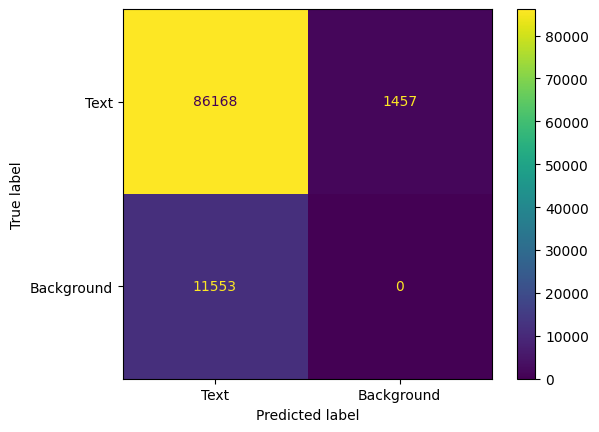

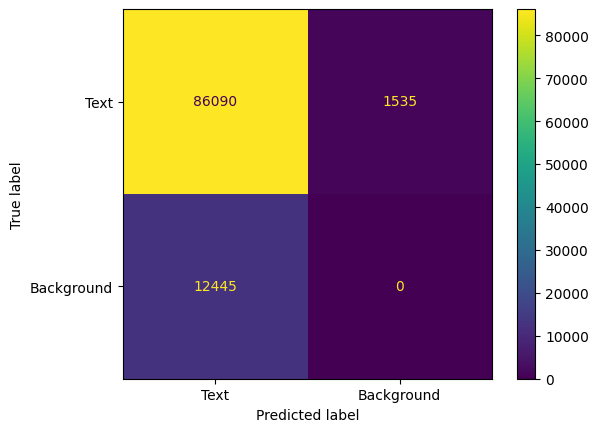

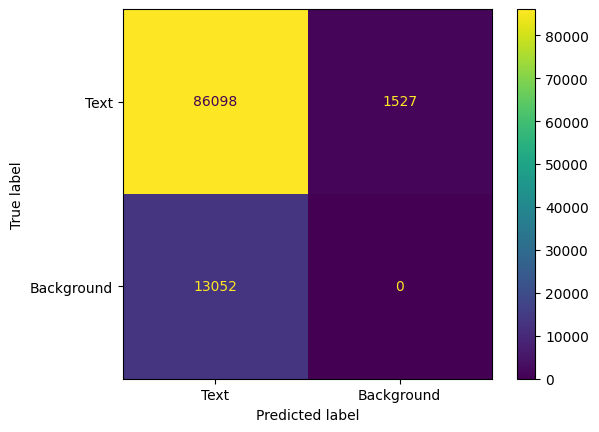

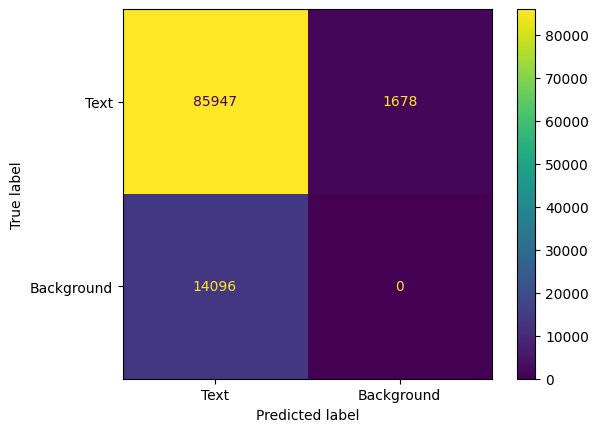

In [ ]:
save_results(model_names_512, "V2_big")
predictions = read_predictions(model_names_512, dataset="V2_big")
pred_to_zip(predictions, model_names_512 )
size_results = read_results(model_names_512, val_dataset)
for i, model_name in enumerate(model_names_512):
  print(model_name)
  coco_eval = size_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

In [ ]:
plot_pr_curves(size_results, model_names_512, 0.5)

## Influence of the training dataset

In [ ]:
model_names_dataset = ["TB512_trunc_R101_finetuned","TB512_trunc_R101_synth" ]

In [ ]:
save_results(model_names_dataset, "V2_big")
predictions = read_predictions(model_names_dataset, dataset="V2_big")
pred_to_zip(predictions, model_names_dataset )
dataset_results = read_results(model_names_dataset, val_dataset)
for i, model_name in enumerate(model_names_dataset):
  print(model_name)
  coco_eval = dataset_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

NameError: ignored

In [ ]:
plot_pr_curves(dataset_results, model_names_dataset, 0.5)

## Top Models

In [ ]:
model_names_top = ["TB512_R152_trunc","SSD512_R152" ]

TB512_R152_trunc
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [8.2m elapsed, 0s remaining, 10.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [8.2m elapsed, 0s remaining, 10.9 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [5.3m elapsed, 0s remaining, 16.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [5.3m elapsed, 0s remaining, 16.2 samples/s]      


TB512_R152_trunc
    ICDAR: {'precision': 0.9267577080734295, 'recall': 0.9392433666191258, 'hmean': 0.932958765754762}
    DetEval: {'precision': 0.9368606309035818, 'recall': 0.9166539229672112, 'hmean': 0.9266471318478458}
    CocoEval: {'precision': 0.9551755135561055, 'recall': 0.9822310984308131, 'fscore': 0.9685143924560574}
SSD512_R152
    ICDAR: {'precision': 0.9420539325842711, 'recall': 0.9489483594864566, 'hmean': 0.9454885778003836}
    DetEval: {'precision': 0.9492651685393247, 'recall': 0.9272353780314053, 'hmean': 0.9381209603281401}
    CocoEval: {'precision': 0.9696179775280899, 'recall': 0.9848330955777461, 'fscore': 0.977166312809625}


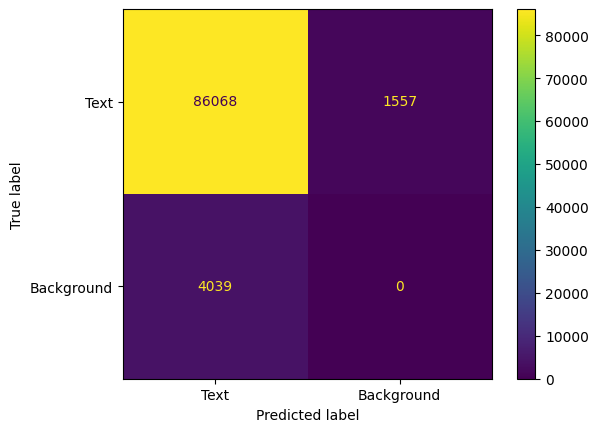

In [ ]:
save_results(model_names_top, "V2_big")
predictions = read_predictions(model_names_top, dataset="V2_big")
pred_to_zip(predictions, model_names_top )
top_results = read_results(model_names_top, val_dataset)
for i, model_name in enumerate(model_names_top):
  print(model_name)
  coco_eval = top_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

In [ ]:
plot_pr_curves(top_results, model_names_top, 0.5)

In [ ]:
predictions = read_predictions(model_names_top, dataset="visu") 
view = vis_dataset.clone()
for i, model_name in enumerate(model_names_top):
  fouc.add_coco_labels(view, model_name, predictions[i], classes,coco_id_field="coco_id")

In [ ]:
session = fo.launch_app(view)

## Influence of nms threshold

In [ ]:
model_names_nms = ["TB512_R152_trunc","TB512_R152_trunc_nms" ,"SSD512_R152","SSD512_R152_nms"]

SSD512_R152_nms
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [7.9m elapsed, 0s remaining, 11.8 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [7.9m elapsed, 0s remaining, 11.8 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [4.7m elapsed, 0s remaining, 12.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [4.7m elapsed, 0s remaining, 12.4 samples/s]      


TB512_R152_trunc
    ICDAR: {'precision': 0.9267577080734295, 'recall': 0.9392433666191258, 'hmean': 0.932958765754762}
    DetEval: {'precision': 0.9368606309035818, 'recall': 0.9166539229672112, 'hmean': 0.9266471318478458}
    CocoEval: {'precision': 0.9551755135561055, 'recall': 0.9822310984308131, 'fscore': 0.9685143924560574}
TB512_R152_trunc_nms
    ICDAR: {'precision': 0.940772909935265, 'recall': 0.9252519258202613, 'hmean': 0.9329478686436687}
    DetEval: {'precision': 0.9439159689168389, 'recall': 0.9141340941512331, 'hmean': 0.9287863511878538}
    CocoEval: {'precision': 0.9811079053664166, 'recall': 0.9701911554921541, 'fscore': 0.9756189929708793}
SSD512_R152
    ICDAR: {'precision': 0.9420539325842711, 'recall': 0.9489483594864566, 'hmean': 0.9454885778003836}
    DetEval: {'precision': 0.9492651685393247, 'recall': 0.9272353780314053, 'hmean': 0.9381209603281401}
    CocoEval: {'precision': 0.9696179775280899, 'recall': 0.9848330955777461, 'fscore': 0.977166312809625}

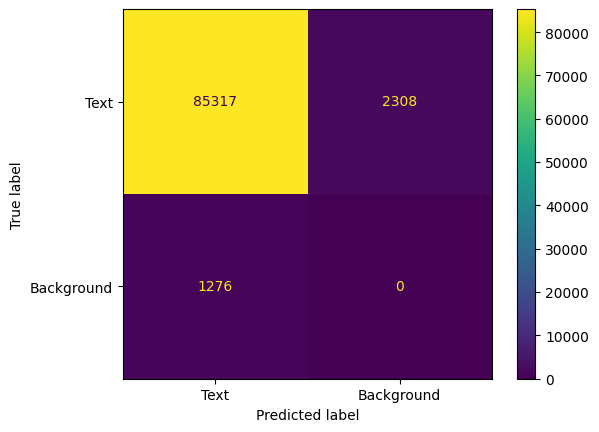

In [ ]:
save_results(model_names_nms, "V2_big")
predictions = read_predictions(model_names_nms, dataset="V2_big")
pred_to_zip(predictions, model_names_nms )
top_results = read_results(model_names_nms, val_dataset)
for i, model_name in enumerate(model_names_nms):
  print(model_name)
  coco_eval = top_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

In [ ]:
model_names_nms = ["TB512_R152_trunc_nms35","SSD512_R152_nms35"]

TB512_R152_trunc_nms35
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [8.4m elapsed, 0s remaining, 10.2 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [8.4m elapsed, 0s remaining, 10.2 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [5.5m elapsed, 0s remaining, 15.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [5.5m elapsed, 0s remaining, 15.6 samples/s]      


SSD512_R152_nms35
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [9.7m elapsed, 0s remaining, 10.5 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [9.7m elapsed, 0s remaining, 10.5 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.3m elapsed, 0s remaining, 6.0 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.3m elapsed, 0s remaining, 6.0 samples/s]       


TB512_R152_trunc_nms35
    ICDAR: {'precision': 0.9361702613781786, 'recall': 0.9309922967189793, 'hmean': 0.9335740993528703}
    DetEval: {'precision': 0.9409911350758547, 'recall': 0.9127532097004494, 'hmean': 0.9266570994651371}
    CocoEval: {'precision': 0.9724421057406609, 'recall': 0.9785791726105564, 'fscore': 0.9755009869001098}
SSD512_R152_nms35
    ICDAR: {'precision': 0.9470283943302508, 'recall': 0.944550071326682, 'hmean': 0.9457876092942008}
    DetEval: {'precision': 0.9514174376737627, 'recall': 0.9264798858773395, 'hmean': 0.9387830825711398}
    CocoEval: {'precision': 0.9801171323093751, 'recall': 0.9816718972895863, 'fscore': 0.9808938987051639}


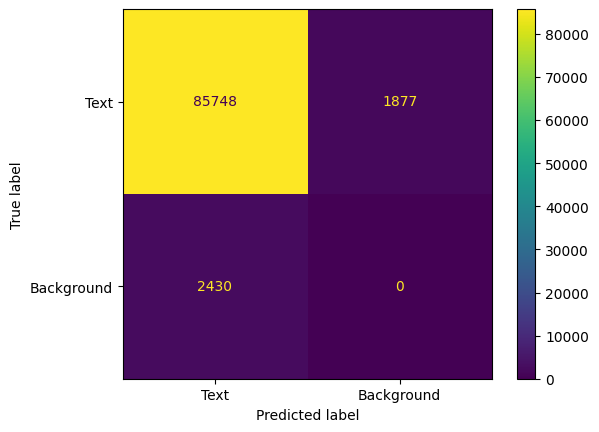

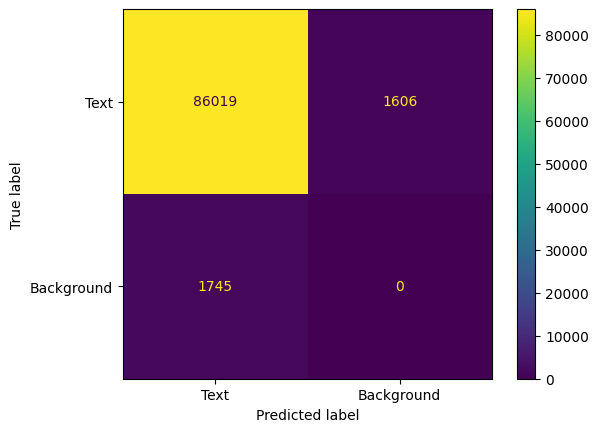

In [ ]:
save_results(model_names_nms, "V2_big")
predictions = read_predictions(model_names_nms, dataset="V2_big")
pred_to_zip(predictions, model_names_nms )
top_results = read_results(model_names_nms, val_dataset)
for i, model_name in enumerate(model_names_nms):
  print(model_name)
  coco_eval = top_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

## Textboxes with different backbones (Resnet50, Resnet18, Resnet152)


In [ ]:
model_names_backbone = ["Textboxes","Textboxes18","Textboxes152"]

In [ ]:
predictions_backbone = read_predictions(model_names_backbone, dataset="visu") 
backboneView = vis_dataset.clone()
for i, model_name in enumerate(model_names_backbone):
  fouc.add_coco_labels(backboneView, model_name, predictions_backbone[i], classes,coco_id_field="coco_id")

NameError: ignored

In [ ]:
session_backbone = fo.launch_app(backboneView)

In [ ]:
backbone_results = read_results(model_names_backbone, val_dataset)
for i, model_name in enumerate(model_names_backbone):
  print(model_name)
  backbone_results[i].print_report()

Textboxes
              precision    recall  f1-score   support

        text       0.16      0.79      0.27     87625

   micro avg       0.16      0.79      0.27     87625
   macro avg       0.16      0.79      0.27     87625
weighted avg       0.16      0.79      0.27     87625

Textboxes18
              precision    recall  f1-score   support

        text       0.16      0.76      0.27     87625

   micro avg       0.16      0.76      0.27     87625
   macro avg       0.16      0.76      0.27     87625
weighted avg       0.16      0.76      0.27     87625

Textboxes152
              precision    recall  f1-score   support

        text       0.19      0.78      0.31     87625

   micro avg       0.19      0.78      0.31     87625
   macro avg       0.19      0.78      0.31     87625
weighted avg       0.19      0.78      0.31     87625



In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import classification_report
print(recall_score(backbone_results[0].ytrue, backbone_results[0].ypred, pos_label = "text", labels = ["text"]))
print(fbeta_score(backbone_results[0].ytrue, backbone_results[0].ypred, pos_label = "text", beta=0.5, labels = ["text"]))
report_str = classification_report(backbone_results[0].ytrue, backbone_results[0].ypred, labels = ["text"])
print(report_str)

0.794944365192582
0.19560627921513743
              precision    recall  f1-score   support

        text       0.16      0.79      0.27     87625

   micro avg       0.16      0.79      0.27     87625
   macro avg       0.16      0.79      0.27     87625
weighted avg       0.16      0.79      0.27     87625



In [ ]:
plot_pr_curves(backbone_results, model_names_backbone,0.5)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import eta.core.utils as etau
import numpy as np
import fiftyone as fo
from fiftyone.utils.eval.coco import COCODetectionResults

_DEFAULT_LAYOUT = dict(
    template="ggplot2", margin={"r": 0, "t": 30, "l": 0, "b": 0}
)

ref_iou_threshs = np.arange(0.5,1,0.05)

def _get_qualitative_colors(num_classes, colors=None):
    # Some color choices:
    # https://plotly.com/python/discrete-color/#color-sequences-in-plotly-express
    if colors is None:
        if num_classes == 1:
            colors = ["#FF6D04"]
        elif num_classes <= 10:
            colors = px.colors.qualitative.G10
        else:
            colors = px.colors.qualitative.Alphabet
    colors = list(colors)
    return [colors[i % len(colors)] for i in range(num_classes)]

def _get_iou_thresh_inds(iou_thresh=None):
  if iou_thresh is None:
      return np.arange(len(ref_iou_threshs))

  if etau.is_numeric(iou_thresh):
      iou_threshs = [iou_thresh]
  else:
      iou_threshs = iou_thresh

  thresh_inds = []
  for iou_thresh in iou_threshs:
    found = False
    for idx, ref_iou_thresh in enumerate(ref_iou_threshs):
      if np.abs(float(iou_thresh) - ref_iou_thresh) < 1e-6:
        thresh_inds.append(idx)
        found = True
        break
    if not found:
      raise ValueError(
          "Invalid IoU threshold %f. Refer to `results.iou_threshs` "
          "to see the available values" % iou_thresh
      )

  return thresh_inds


def plot_AP_vs_iou(results, model_names):
    iou_thresh = ref_iou_threshs
    thresh_inds = _get_iou_thresh_inds(iou_thresh=iou_thresh)

    AP = [[] for _ in model_names]

    for thresh_idx in thresh_inds:
      precisions = []
      for i in range(len(model_names)):
        class_id = 0
        precisions.append(
            np.mean(results[i].precision[[thresh_idx], class_id], axis=0)
        )
      avg_precisions = np.mean(precisions, axis=1)
      for i in range(len(model_names)):
        avg_precision = avg_precisions[i]
        AP[i].append(avg_precision)


    figure = go.Figure()
    colors = _get_qualitative_colors(len(model_names))

    for idx, color in enumerate(colors):
        _model = model_names[idx]
        label = "%s" % (_model)

        line = go.Scatter(
            x=iou_thresh,
            y=AP[idx],
            name=label,
            mode="lines",
            line_color=color
        )

        figure.add_trace(line)

    figure.update_layout(
        xaxis=dict(range=[0.5, 1], constrain="domain"),
        yaxis=dict(
            range=[0, 1], constrain="domain"
        ),
        xaxis_title="iou threshold",
        yaxis_title="Average Precision",
        title="iou vs AP",
    )

    figure.update_layout(**_DEFAULT_LAYOUT)

    return figure


In [ ]:
for i, model_name in enumerate(model_names_backbone):
  cm, _, _ = backbone_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

## Splitting the image in 4

In [ ]:
model_names_split = ["TextboxesNorm","TextboxesNorm_split","Textboxes152Norm_split","Textboxes152Norm"]

In [ ]:
predictions_split = read_predictions(model_names_split, dataset="visu") 
splitView = vis_dataset.clone()
for i, model_name in enumerate(model_names_split):
  fouc.add_coco_labels(splitView, model_name, predictions_split[i], classes,coco_id_field="coco_id")

In [ ]:
session_split = fo.launch_app(splitView)

In [ ]:
split_results = read_results(model_names_split, val_dataset)
for i, model_name in enumerate(model_names_split):
  print(model_name)
  split_results[i].print_report()

TextboxesNorm
              precision    recall  f1-score   support

        text       0.16      0.79      0.27     87625

   micro avg       0.16      0.79      0.27     87625
   macro avg       0.16      0.79      0.27     87625
weighted avg       0.16      0.79      0.27     87625

TextboxesNorm_split
              precision    recall  f1-score   support

        text       0.14      0.82      0.24     87625

   micro avg       0.14      0.82      0.24     87625
   macro avg       0.14      0.82      0.24     87625
weighted avg       0.14      0.82      0.24     87625

Textboxes152Norm_split
              precision    recall  f1-score   support

        text       0.19      0.79      0.30     87625

   micro avg       0.19      0.79      0.30     87625
   macro avg       0.19      0.79      0.30     87625
weighted avg       0.19      0.79      0.30     87625

Textboxes152Norm
              precision    recall  f1-score   support

        text       0.20      0.78      0.31     8762

In [ ]:
plot_pr_curves(split_results, model_names_split, 0.5)

In [ ]:
for i, model_name in enumerate(model_names_split):
  cm, _, _ = split_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

## New Training dataset

In [ ]:
model_names_newTrain = ["TextboxesNorm","NewTextboxes50Norm_big","NewTextboxes50Norm_big_split"]

In [ ]:
predictions_newTrain = read_predictions(model_names_newTrain, dataset="visu") 
newTrainView = vis_dataset.clone()
for i, model_name in enumerate(model_names_newTrain):
  fouc.add_coco_labels(newTrainView, model_name, predictions_newTrain[i], classes,coco_id_field="coco_id")

In [ ]:
session_newTrain = fo.launch_app(newTrainView)

In [ ]:
newTrain_results = read_results(model_names_newTrain, val_dataset)
for i, model_name in enumerate(model_names_newTrain):
  print(model_name)
  newTrain_results[i].print_report()

TextboxesNorm
              precision    recall  f1-score   support

        text       0.16      0.79      0.27     87625

   micro avg       0.16      0.79      0.27     87625
   macro avg       0.16      0.79      0.27     87625
weighted avg       0.16      0.79      0.27     87625

NewTextboxes50Norm_big
              precision    recall  f1-score   support

        text       0.17      0.88      0.28     87625

   micro avg       0.17      0.88      0.28     87625
   macro avg       0.17      0.88      0.28     87625
weighted avg       0.17      0.88      0.28     87625

NewTextboxes50Norm_big_split
              precision    recall  f1-score   support

        text       0.18      0.89      0.31     87625

   micro avg       0.18      0.89      0.31     87625
   macro avg       0.18      0.89      0.31     87625
weighted avg       0.18      0.89      0.31     87625



In [ ]:
plot_pr_curves(newTrain_results, model_names_newTrain)

In [ ]:
for i, model_name in enumerate(model_names_newTrain):
  cm, _, _ = newTrain_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

## TB 512 on New Big Training dataset

In [ ]:
model_names_512 = ["NewTextboxes50Norm_big","TB512_R50_newBig","NewTextboxes50Norm_big_split", "TB512_R50_newBig_split"]

In [ ]:
predictions_512 = read_predictions(model_names_512, dataset="visu") 
TB512View = vis_dataset.clone()
for i, model_name in enumerate(model_names_512):
  fouc.add_coco_labels(TB512View, model_name, predictions_512[i], classes,coco_id_field="coco_id")

In [ ]:
session_512 = fo.launch_app(TB512View)

In [ ]:
TB512_results = read_results(model_names_512, val_dataset)
for i, model_name in enumerate(model_names_512):
  print(model_name)
  TB512_results[i].print_report()

NewTextboxes50Norm_big
              precision    recall  f1-score   support

        text       0.17      0.88      0.28     87625

   micro avg       0.17      0.88      0.28     87625
   macro avg       0.17      0.88      0.28     87625
weighted avg       0.17      0.88      0.28     87625

TB512_R50_newBig
              precision    recall  f1-score   support

        text       0.20      0.83      0.32     87625

   micro avg       0.20      0.83      0.32     87625
   macro avg       0.20      0.83      0.32     87625
weighted avg       0.20      0.83      0.32     87625

NewTextboxes50Norm_big_split
              precision    recall  f1-score   support

        text       0.18      0.89      0.31     87625

   micro avg       0.18      0.89      0.31     87625
   macro avg       0.18      0.89      0.31     87625
weighted avg       0.18      0.89      0.31     87625

TB512_R50_newBig_split
              precision    recall  f1-score   support

        text       0.18      0.85 

In [ ]:
plot_pr_curves(TB512_results, model_names_512,0.5)

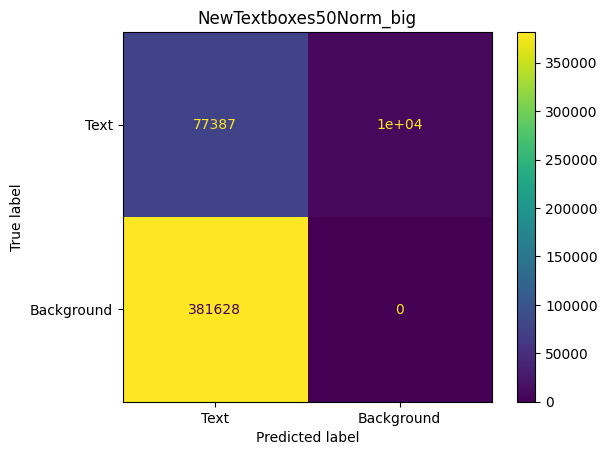

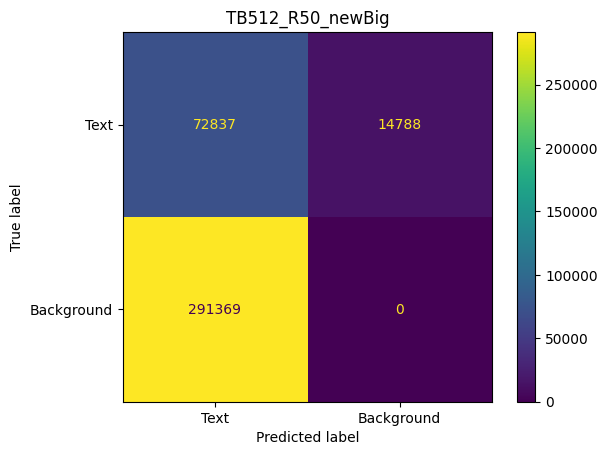

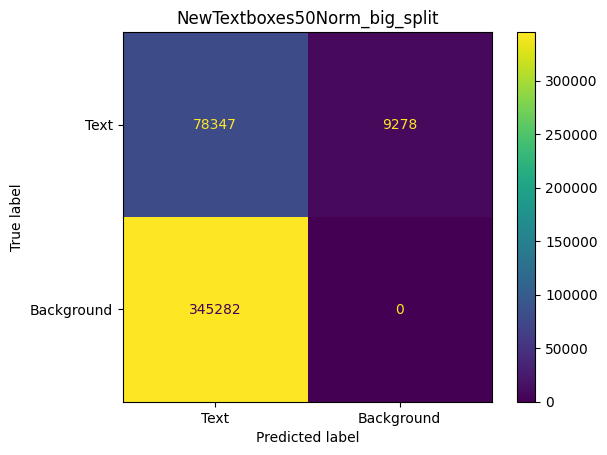

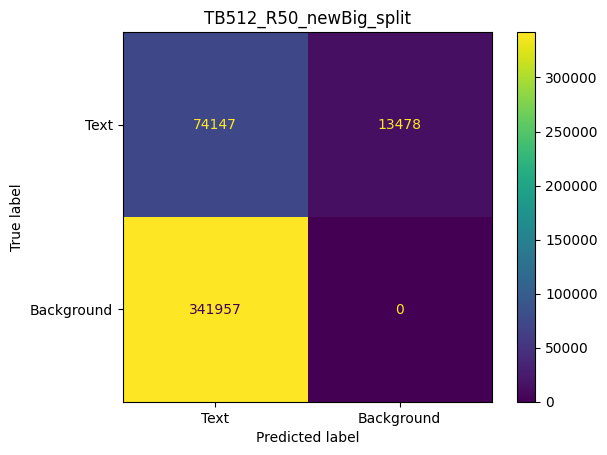

In [ ]:
for i, model_name in enumerate(model_names_512):
  cm, _, _ = TB512_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

## TB 300 pretrained on small SynthText (45 epochs) + finetuned on new big training set (20 epochs)

In [ ]:
model_names_finetuned = ["NewTextboxes50Norm_big","TB512_R50_newBig","TB300_R50_newBig_pretrained"]

In [ ]:
predictions_finetuned = read_predictions(model_names_finetuned, dataset="visu") 
finetunedView = vis_dataset.clone()
for i, model_name in enumerate(model_names_finetuned):
  fouc.add_coco_labels(finetunedView, model_name, predictions_finetuned[i], classes,coco_id_field="coco_id")

In [ ]:
session_finetuned = fo.launch_app(finetunedView)

In [ ]:
finedtuned_results = read_results(model_names_finetuned, val_dataset)
for i, model_name in enumerate(model_names_finetuned):
  print(model_name)
  finedtuned_results[i].print_report()

NewTextboxes50Norm_big
              precision    recall  f1-score   support

        text       0.17      0.88      0.28     87625

   micro avg       0.17      0.88      0.28     87625
   macro avg       0.17      0.88      0.28     87625
weighted avg       0.17      0.88      0.28     87625

TB512_R50_newBig
              precision    recall  f1-score   support

        text       0.20      0.83      0.32     87625

   micro avg       0.20      0.83      0.32     87625
   macro avg       0.20      0.83      0.32     87625
weighted avg       0.20      0.83      0.32     87625

TB300_R50_newBig_pretrained
              precision    recall  f1-score   support

        text       0.20      0.85      0.33     87625

   micro avg       0.20      0.85      0.33     87625
   macro avg       0.20      0.85      0.33     87625
weighted avg       0.20      0.85      0.33     87625



In [ ]:
plot_pr_curves(finedtuned_results, model_names_finetuned, 0.65)

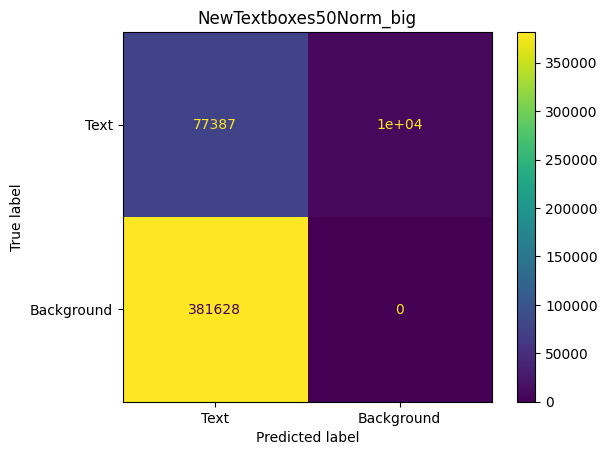

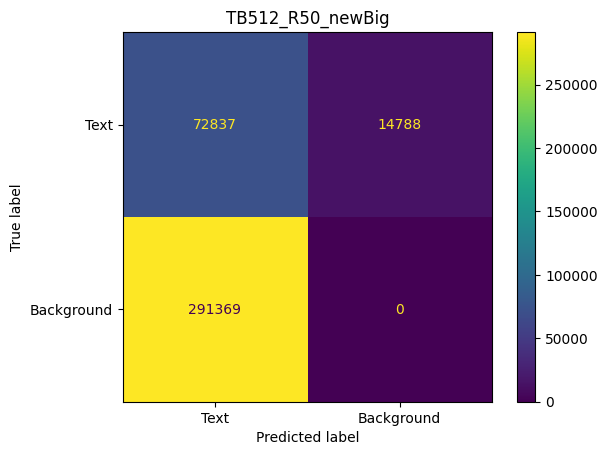

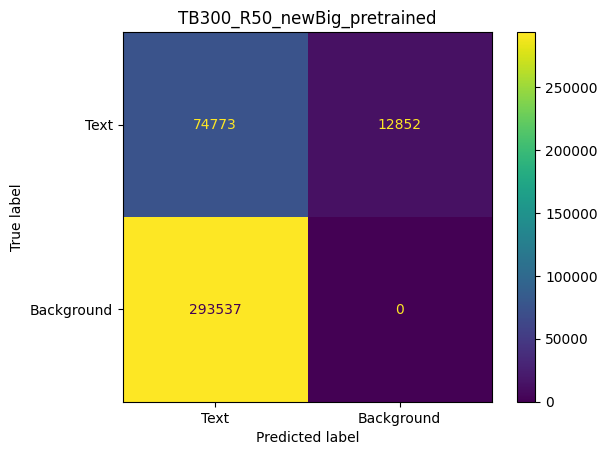

In [ ]:
for i, model_name in enumerate(model_names_finetuned):
  cm, _, _ = finedtuned_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

## Real Textboxes without offset

In [ ]:
#model_names_real = ["realTB300_R50_newBig","realTB300_trunc_R50_newBig"]
model_names_real = ["realTB300_noOffset_R50_newBig","realTB300_noOffset_trunc_R50_newBig","realTB512_noOffset_R50_newBig","realTB512_noOffset_trunc_R50_newBig"]

In [ ]:
predictions_real = read_predictions(model_names_real, dataset="visu") 
realView = vis_dataset.clone()
for i, model_name in enumerate(model_names_real):
  fouc.add_coco_labels(realView, model_name, predictions_real[i], classes,coco_id_field="coco_id")

NameError: ignored

In [ ]:
model_names_real = ["realTB300_noOffset_R50_newBig","realTB512_noOffset_R50_newBig"]
val_predictions_real = read_predictions(model_names_real, dataset="new_custom_v2") 

In [ ]:
pred_to_zip(val_predictions_real,model_names_real)

NameError: ignored

In [ ]:
session_real = fo.launch_app(realView)

In [ ]:
real_results = read_results(model_names_real, val_dataset)
for i, model_name in enumerate(model_names_real):
  print(model_name)
  real_results[i].print_report()

realTB300_noOffset_R50_newBig
              precision    recall  f1-score   support

        text       0.70      0.94      0.80     87625

   micro avg       0.70      0.94      0.80     87625
   macro avg       0.70      0.94      0.80     87625
weighted avg       0.70      0.94      0.80     87625

realTB300_noOffset_trunc_R50_newBig
              precision    recall  f1-score   support

        text       0.72      0.94      0.82     87625

   micro avg       0.72      0.94      0.82     87625
   macro avg       0.72      0.94      0.82     87625
weighted avg       0.72      0.94      0.82     87625

realTB512_noOffset_R50_newBig
              precision    recall  f1-score   support

        text       0.85      0.98      0.91     87625

   micro avg       0.85      0.98      0.91     87625
   macro avg       0.85      0.98      0.91     87625
weighted avg       0.85      0.98      0.91     87625

realTB512_noOffset_trunc_R50_newBig
              precision    recall  f1-score   sup

In [ ]:
plot_pr_curves(real_results, model_names_real, 0.5)

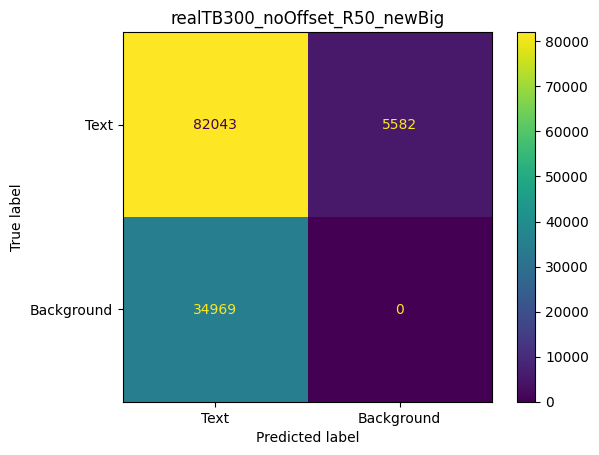

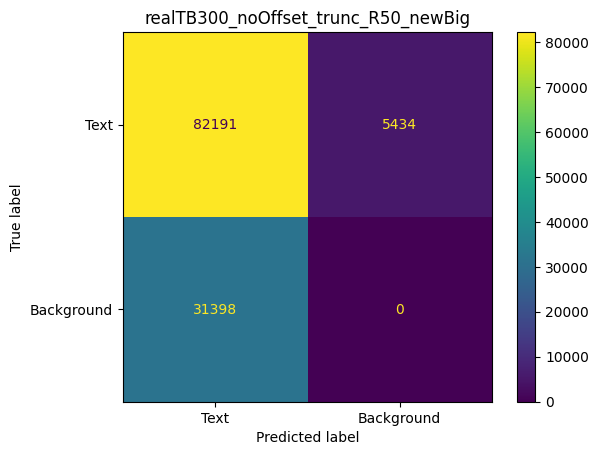

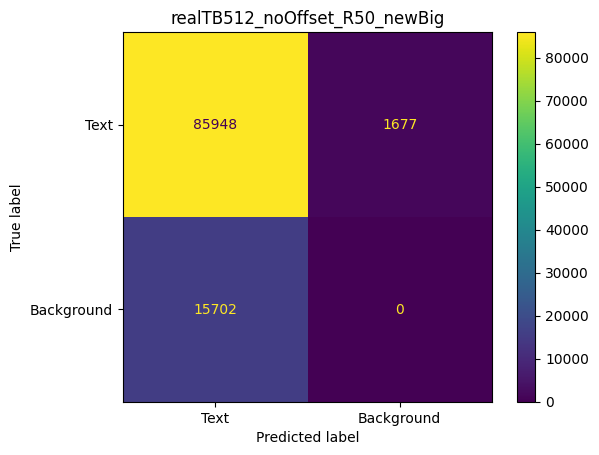

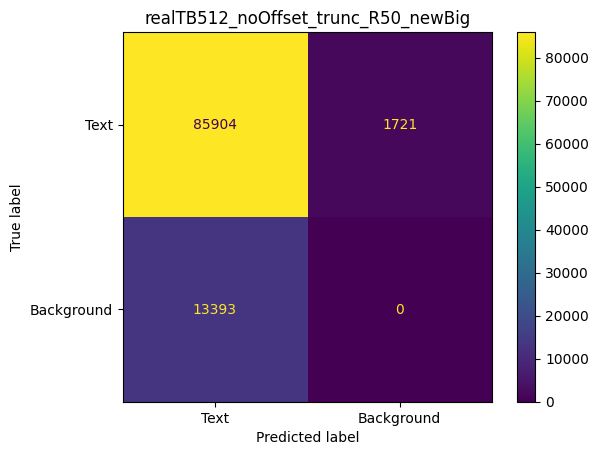

In [ ]:
for i, model_name in enumerate(model_names_real):
  cm, _, _ = real_results[i]._confusion_matrix(include_other = None, include_missing = None)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ["Text", "Background"])
  
  disp.plot()
  disp.ax_.set_title(model_name)

### Real TB512 trunc without offset with different backbones

In [ ]:
model_names_real_backbones = ["realTB512_noOffset_trunc_R18_newBig","realTB512_noOffset_trunc_R34_newBig","realTB512_noOffset_trunc_R50_newBig","realTB512_noOffset_trunc_R101_newBig","realTB512_noOffset_trunc_R152_newBig"]

In [ ]:
predictions_real_backbones = read_predictions(model_names_real_backbones, dataset="visu") 
realBackboneView = vis_dataset.clone()
for i, model_name in enumerate(model_names_real_backbones):
  fouc.add_coco_labels(realBackboneView, model_name, predictions_real_backbones[i], classes,coco_id_field="coco_id")

In [ ]:
session_real_backbones = fo.launch_app(realBackboneView)

In [ ]:
predictions = read_predictions(model_names_real_backbones, "new_custom_v2")
pred_to_zip(predictions, model_names_real_backbones )
real_backbones_results = read_results(model_names_real_backbones, val_dataset)
for i, model_name in enumerate(model_names_real_backbones):
  print(model_name)
  coco_eval = real_backbones_results[i].metrics()
  del coco_eval["accuracy"]
  del coco_eval["support"]
  print("    ICDAR: " + str(ICDAR_results(model_name)))
  print("    DetEval: " + str(DetEval_results(model_name)))
  print("    CocoEval: " +str(coco_eval))

realTB512_noOffset_trunc_R18_newBig
    ICDAR: {'precision': 0.5921810671113541, 'recall': 0.9208536376605054, 'hmean': 0.7208190110687439}
    DetEval: {'precision': 0.6373744992077279, 'recall': 0.8900245363766124, 'hmean': 0.7428038514357297}
    CocoEval: {'precision': 0.589990382020606, 'recall': 0.9730784593437946, 'fscore': 0.7345894394045126}
realTB512_noOffset_trunc_R34_newBig
    ICDAR: {'precision': 0.8491813188531191, 'recall': 0.9082910128388172, 'hmean': 0.8777421371320938}
    DetEval: {'precision': 0.8700970327368212, 'recall': 0.8891708987161379, 'hmean': 0.8795305669328981}
    CocoEval: {'precision': 0.8717586044318718, 'recall': 0.9706590584878745, 'fscore': 0.9185543573931778}
realTB512_noOffset_trunc_R50_newBig
    ICDAR: {'precision': 0.8469782571477495, 'recall': 0.94116519258204, 'hmean': 0.8915911691779772}
    DetEval: {'precision': 0.8672407021360155, 'recall': 0.917235948644813, 'hmean': 0.8915379730847727}
    CocoEval: {'precision': 0.8651218062982768, 'r

In [ ]:
real_backbones_results = read_results(model_names_real_backbones, val_dataset)
for i, model_name in enumerate(model_names_real_backbones):
  print(model_name)
  real_backbones_results[i].print_report()

realTB512_noOffset_trunc_R18_newBig
              precision    recall  f1-score   support

        text       0.59      0.97      0.73     87625

   micro avg       0.59      0.97      0.73     87625
   macro avg       0.59      0.97      0.73     87625
weighted avg       0.59      0.97      0.73     87625

realTB512_noOffset_trunc_R34_newBig
              precision    recall  f1-score   support

        text       0.87      0.97      0.92     87625

   micro avg       0.87      0.97      0.92     87625
   macro avg       0.87      0.97      0.92     87625
weighted avg       0.87      0.97      0.92     87625

realTB512_noOffset_trunc_R50_newBig
              precision    recall  f1-score   support

        text       0.87      0.98      0.92     87625

   micro avg       0.87      0.98      0.92     87625
   macro avg       0.87      0.98      0.92     87625
weighted avg       0.87      0.98      0.92     87625

realTB512_noOffset_trunc_R101_newBig
              precision    recall  f

In [ ]:
plot_pr_curves(real_backbones_results, model_names_real_backbones,0.5)

In [ ]:
plot_AP_vs_iou(real_backbones_results, model_names_real_backbones)

### Real TB512 Resnet 101 trunc without offset finetuned

In [ ]:
model_names_real_finetuned = ["realTB512_noOffset_trunc_R101_finetuned","realTB512_noOffset_trunc_R101_newBig"]

In [ ]:
predictions_real_finetuned = read_predictions(model_names_real_finetuned, dataset="visu") 
realFinetunedView = vis_dataset.clone()
for i, model_name in enumerate(model_names_real_finetuned):
  fouc.add_coco_labels(realFinetunedView, model_name, predictions_real_finetuned[i], classes,coco_id_field="coco_id")

In [ ]:
session_real_finetuned = fo.launch_app(realFinetunedView)

realTB512_noOffset_trunc_R101_finetuned
Evaluating detections...


INFO:fiftyone.utils.eval.detection:Evaluating detections...


 100% |███████████████| 3863/3863 [9.9m elapsed, 0s remaining, 8.8 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [9.9m elapsed, 0s remaining, 8.8 samples/s]       


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 3863/3863 [6.1m elapsed, 0s remaining, 7.7 samples/s]       


INFO:eta.core.utils: 100% |███████████████| 3863/3863 [6.1m elapsed, 0s remaining, 7.7 samples/s]       


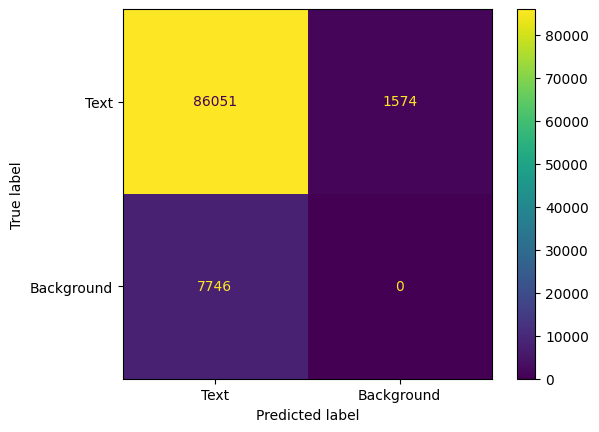

In [ ]:
save_results(model_names_real_finetuned)

In [ ]:
real_finetuned_results = read_results(model_names_real_finetuned, val_dataset)
for i, model_name in enumerate(model_names_real_finetuned):
  print(model_name)
  real_finetuned_results[i].print_report()

realTB512_noOffset_trunc_R101_finetuned
              precision    recall  f1-score   support

        text       0.92      0.98      0.95     87625

   micro avg       0.92      0.98      0.95     87625
   macro avg       0.92      0.98      0.95     87625
weighted avg       0.92      0.98      0.95     87625

realTB512_noOffset_trunc_R101_newBig
              precision    recall  f1-score   support

        text       0.93      0.98      0.96     87625

   micro avg       0.93      0.98      0.96     87625
   macro avg       0.93      0.98      0.96     87625
weighted avg       0.93      0.98      0.96     87625



In [ ]:
plot_pr_curves(real_finetuned_results, model_names_real_finetuned,0.5)